In [1]:
import os
import numpy as np
import muspy
from tqdm import tqdm
import config
import utils
import tarfile
import shutil
import collections
from matplotlib import pyplot as plt
import json
import tensorflow as tf
import pickle
import json
import pprint
import subprocess
from sklearn.metrics import multilabel_confusion_matrix

import pandas as pd

config_string = "single_instruments_type"
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

conf = config.Config(config_string, ROOT_PATH)

/Users/marcelloceresini/miniconda/envs/env-MusicGeneration/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
y_true = np.array([[1, 0, 0], [0, 1, 0]])
y_pred = np.array([[1, 0, 1], [0, 1, 0]])

multilabel_confusion_matrix(y_true, y_pred)

array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [0, 1]],

       [[1, 1],
        [0, 0]]])

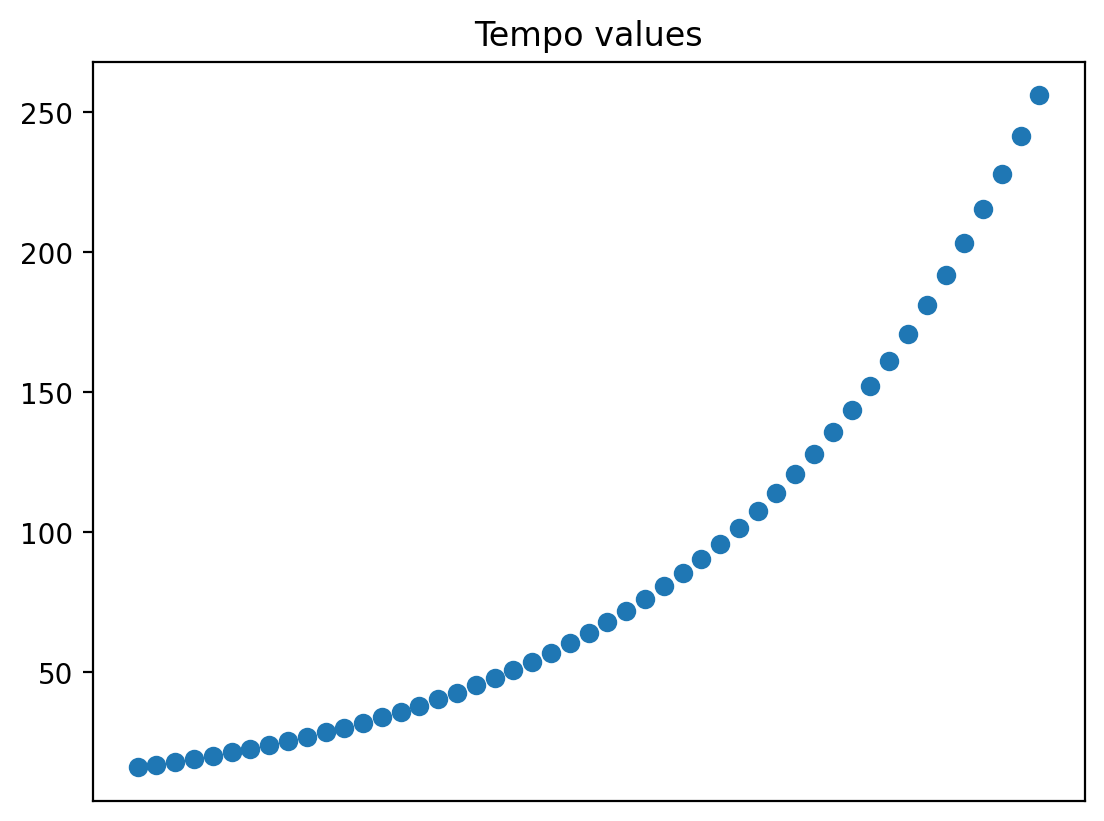

In [13]:
plt.scatter(range(len(conf.np_tempos)), conf.np_tempos)
plt.title("Tempo values")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [11]:
conf.np_tempos

array([ 16.        ,  16.95140951,  17.95939277,  19.02731384,
        20.1587368 ,  21.35743767,  22.627417  ,  23.97291323,
        25.39841683,  26.90868529,  28.50875898,  30.20397801,
        32.        ,  33.90281902,  35.91878555,  38.05462768,
        40.3174736 ,  42.71487533,  45.254834  ,  47.94582646,
        50.79683366,  53.81737058,  57.01751796,  60.40795601,
        64.        ,  67.80563804,  71.83757109,  76.10925536,
        80.63494719,  85.42975067,  90.50966799,  95.89165292,
       101.59366733, 107.63474115, 114.03503592, 120.81591202,
       128.        , 135.61127608, 143.67514218, 152.21851072,
       161.26989439, 170.85950133, 181.01933598, 191.78330584,
       203.18733465, 215.2694823 , 228.07007184, 241.63182405,
       256.        ])

In [2]:
lmd_matched = utils.get_dataset("lmd_matched", conf)

In [3]:
for song in lmd_matched:
    if len(song.time_signatures) > 4:
        original_song = song
        break

In [4]:
original_song.time_signatures

[TimeSignature(time=0, numerator=4, denominator=4),
 TimeSignature(time=0, numerator=4, denominator=4),
 TimeSignature(time=0, numerator=4, denominator=4),
 TimeSignature(time=0, numerator=4, denominator=4),
 TimeSignature(time=0, numerator=4, denominator=4),
 TimeSignature(time=0, numerator=4, denominator=4),
 TimeSignature(time=0, numerator=4, denominator=4),
 TimeSignature(time=0, numerator=4, denominator=4),
 TimeSignature(time=0, numerator=4, denominator=4),
 TimeSignature(time=0, numerator=4, denominator=4)]

In [5]:
tmp_converted_song = utils.transform_representation(original_song, conf)
converted_song = utils.anti_tranform_representation(tmp_converted_song, conf)

In [6]:
def get_column_value_percentages_over_dataset(column, dataset, fraction_of_dataset=0.1, bad_song=False):
    size = round(len(dataset)*fraction_of_dataset)
    print(len(dataset), size)
    i = 0

    random_indices = np.random.randint(low=0, high=len(dataset)-1, size=size)

    while i<size:
        
        song = dataset[random_indices[i]]
        tmp_converted_song = utils.transform_representation(song, conf)
        
        if len(tmp_converted_song) > 1:
            
            df_song = pd.DataFrame(tmp_converted_song)

            value_counts = df_song[column].value_counts()

            instrument_rows = df_song[df_song[6] == 0]
            instrument_rows = instrument_rows[instrument_rows[0]==3]

            duration_of_instrument_rows = instrument_rows[4].value_counts()
            value_counts_instrument = instrument_rows[column].value_counts()
            
            if bad_song and (0 in duration_of_instrument_rows.keys()):
                tot_piano_notes = duration_of_instrument_rows.sum()
                print("bbb")
                if duration_of_instrument_rows[0]/tot_piano_notes > 0.5 and tot_piano_notes>50:
                    print(tot_piano_notes, duration_of_instrument_rows[0], "aaa")
                    print(duration_of_instrument_rows)
                    print(instrument_rows)
                    index_of_bad_song = random_indices[i]
                    print("----")
                    tmp = instrument_rows.groupby(4)[7].value_counts().sort_index()
                    print(tmp)
                    return 0, 0, 0, (tmp, index_of_bad_song)

            duration_0_rows = df_song[df_song[4] == 0]
            instruments_duration_0 = duration_0_rows[6].value_counts()

            if i == 0:
                result = value_counts.copy()
                result_instrument = value_counts_instrument.copy()
                results_duration_0 = instruments_duration_0.copy()
            else:
                result = result.add(value_counts, fill_value=0).astype(int)
                result_instrument = result_instrument.add(value_counts_instrument, fill_value=0).astype(int)
                results_duration_0 = results_duration_0.add(instruments_duration_0, fill_value=0).astype(int)

        i+=1

    return result.sort_index(), result_instrument.sort_index(), results_duration_0.sort_index(), None

In [7]:
# tot_count_values, tot_instrument_values, instruments_dur_0, _ = get_column_value_percentages_over_dataset(column=4, dataset=lmd_matched, fraction_of_dataset=0.01)
_, _, _, (tmp, idx) = get_column_value_percentages_over_dataset(column=4, dataset=lmd_matched, fraction_of_dataset=0.01, bad_song=True)

115190 1152
bbb
bbb
bbb
1483 1247 aaa
0     1247
10      18
21      16
24      14
11      14
23      14
20      12
15      12
8       12
7       10
16      10
22       8
48       8
36       8
18       6
57       6
25       6
40       6
17       6
14       4
41       4
26       4
47       4
39       4
13       4
51       4
19       4
35       4
5        4
4        2
27       2
42       2
6        2
9        2
Name: 4, dtype: int64
      0    1   2   3   4   5   6    7   8   9   10
19     3    0   1   1   0  42   0  127   1  41  26
20     3    0   2   1   0  42   0  127   1  41  26
21     3    0   3   1   0  42   0  127   1  41  26
170    3    9   0   1   0  38   0   55   1  41  36
171    3    9   0   1   0  48   0  127   1  41  36
...   ..  ...  ..  ..  ..  ..  ..  ...  ..  ..  ..
5739   3  101   3  65   0  42   0   96   1  41  36
5740   3  101   3  97   0  38   0  127   1  41  36
5747   3  102   0   0   0  46   0  127   1  41  26
5749   3  102   0   0   0  36   0  127   1  41  26
5754 

In [8]:
lmd_matched[idx].resolution

96

In [9]:
for track in lmd_matched[idx].tracks:
    if len(track.notes) > 0 :
        print(track.program)

33
1
27
25
110
105
0
0
0
0
0
0
0
0


In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(tmp)

4   7  
0   55      15
    96     368
    127    864
4   127      2
5   127      4
6   127      2
7   127     10
8   127     12
9   127      2
10  127     18
11  127     14
13  127      4
14  127      4
15  127     12
16  127     10
17  127      6
18  127      6
19  127      4
20  127     12
21  127     16
22  127      8
23  127     14
24  127     14
25  127      6
26  127      4
27  127      2
35  127      4
36  127      8
39  127      4
40  127      6
41  127      4
42  127      2
47  127      4
48  127      8
51  127      4
57  127      6
Name: 7, dtype: int64

In [24]:
for note in lmd_matched[idx].tracks[2].notes:
    print(note.velocity)

In [25]:
muspy.outputs.write_midi(
            path="tmp_song.mid",
            music=lmd_matched[idx],
            backend="pretty_midi",
        )

tmp_converted_song = utils.transform_representation(lmd_matched[idx], conf, verbose=True)
converted_song = utils.anti_tranform_representation(tmp_converted_song, conf)

muspy.outputs.write_midi(
            path="tmp_song_cleaned.mid",
            music=converted_song,
            backend="pretty_midi",
        )

[2692.   38.   44.  113.    0.]
[3068.   57.  176.  127.   29.]
[3068.   50.  176.  127.   29.]
[3076.   50.   96.   67.   29.]
[3080.   62.  168.  127.   29.]
[3084.   57.   92.   67.   29.]
[3088.   50.  176.   95.   30.]
[3088.   57.  176.   95.   30.]
[3088.   62.  188.   95.   30.]
[3260.   50.   32.  116.   29.]
[3260.   57.   36.  119.   29.]
[3268.   50.   76.   56.   29.]
[3272.   57.   76.   57.   29.]
[3276.   50.   36.   83.   30.]
[3280.   57.   36.   84.   30.]
[3452.   50.   28.   98.   29.]
[3452.   57.   28.   98.   29.]
[3460.   50.   68.   44.   29.]
[3464.   57.   68.   44.   29.]
[3468.   50.   32.   70.   30.]
[3472.   57.   32.   70.   30.]
[3644.   50.  160.  127.   29.]
[3648.   57.  140.  127.   29.]
[3652.   62.  156.  127.   29.]
[3652.   50.  104.   67.   29.]
[3656.   57.  104.   67.   29.]
[3660.   57.  144.   95.   30.]
[3660.   50.  164.   95.   30.]
[3668.   62.  164.   95.   30.]
[3836.   50.   32.  113.   29.]
[3836.   57.   32.  113.   29.]
[3844.  

In [15]:
for track in lmd_matched[idx].tracks:
    if len(track.notes) > 0 :
        print(track.program)

tmp_converted_song = utils.transform_representation(lmd_matched[idx], conf)
converted_song = utils.anti_tranform_representation(tmp_converted_song, conf)

33
1
27
25
110
105
0
0
0
0
0
0
0
0


In [16]:
for track in converted_song.tracks:
    if len(track.notes) > 0 :
        print(track.program)

33
1
27
25
110
105
0


In [15]:
tmp_converted_song = utils.transform_representation(lmd_matched[idx], conf, verbose=True)

[ 0. 42. 12. 56.  0.]
[384.  42.  12.  52.   0.]
[768.  42.  12.  50.   0.]
[1152.   42.   12.   41.    0.]
[1344.   40.  116.   66.   24.]
[1344.   40.   96.   66.   25.]
[1440.   42.  112.   64.   25.]
[1440.   42.   96.   76.   24.]
[1536.   69.  760.   38.   21.]
[1536.   81.   12.   52.    0.]
[1536.   45.  892.   64.   25.]
[1536.   45.  720.   66.   24.]
[1536.   64.   12.   74.    0.]
[1728.   64.   12.   27.    0.]
[1728.   52.   40.   42.   24.]
[1920.   62.   12.   70.    0.]
[1920.   61.   68.   54.   24.]
[1920.   57.   92.   60.   24.]
[1920.   52.  164.   68.   24.]
[1984.   62.   72.   64.   24.]
[2048.   61.   64.   64.   24.]
[2112.   63.   12.   48.    0.]
[2112.   57.  128.   62.   24.]
[2304.   64.  176.   68.   24.]
[2304.   71.  572.   48.   21.]
[2304.   59.  192.   66.   24.]
[2304.   44.  200.   62.   24.]
[2496.   63.   12.   28.    0.]
[2496.   52.   20.   42.   24.]
[2688.   62.   12.   70.    0.]
[2688.   64.  124.   64.   24.]
[2688.   59.  164.   60.   2

In [16]:
for line in tmp_converted_song:
    print(line)

[0 0 0 0 0 0 0 0 0 0 0]
[ 1  0  0  0  0  0 35  0  0  0  0]
[ 1  0  0  0  0  0 24  0  0  0  0]
[ 1  0  0  0  0  0 71  0  0  0  0]
[ 1  0  0  0  0  0 26  0  0  0  0]
[ 1  0  0  0  0  0 21  0  0  0  0]
[ 1  0  0  0  0  0 25  0  0  0  0]
[1 0 0 0 0 0 5 0 0 0 0]
[  1   0   0   0   0   0 128   0   0   0   0]
[2 0 0 0 0 0 0 0 0 0 0]
[4 0 0 0 0 0 0 0 0 0 0]
[ 5  0  0  0  0  0  0  0  0 41  0]
[ 6  0  0  0  0  0  0  0  0  0 28]
[ 3  0  0  0  0 42  0 56  0 41 28]
[ 3  0  1  0  0 42  0 52  0 41 28]
[ 3  0  2  0  0 42  0 50  0 41 28]
[ 3  0  3  0  0 42  0 41  0 41 28]
[ 3  0  3 64  9 40 24 66  0 41 28]
[ 3  0  3 64  7 40 25 66  0 41 28]
[ 3  0  3 96  8 42 25 64  0 41 28]
[ 3  0  3 96  7 42 24 76  0 41 28]
[ 3  1  0  0 47 69 21 38  0 41 28]
[ 3  1  0  0  0 81  0 52  0 41 28]
[ 3  1  0  0 50 45 25 64  0 41 28]
[ 3  1  0  0 45 45 24 66  0 41 28]
[ 3  1  0  0  0 64  0 74  0 41 28]
[ 3  1  0 64  0 64  0 27  0 41 28]
[ 3  1  0 64  2 52 24 42  0 41 28]
[ 3  1  1  0  0 62  0 70  0 41 28]
[ 3  1  1  0  5 61

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(tot_count_values)

NameError: name 'tot_count_values' is not defined

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(tot_instrument_values.divide(tot_instrument_values.sum()))

0      0.226813
1      0.050448
2      0.054435
3      0.050237
4      0.023184
5      0.014322
6      0.042923
7      0.040057
8      0.018893
9      0.017752
10     0.027945
11     0.013544
12     0.031441
13     0.009306
14     0.038655
15     0.067605
16     0.010543
17     0.004525
18     0.007222
19     0.004432
20     0.014559
21     0.003330
22     0.004374
23     0.004844
24     0.003368
25     0.007018
26     0.004477
27     0.004844
28     0.005978
29     0.004522
30     0.021236
31     0.039953
32     0.004916
33     0.004888
34     0.003676
35     0.003332
36     0.004829
37     0.002170
38     0.002305
39     0.003942
40     0.001930
41     0.002418
42     0.004015
43     0.003600
44     0.002644
45     0.001941
46     0.004494
47     0.025468
48     0.002446
49     0.001858
50     0.001829
51     0.001882
52     0.001865
53     0.001435
54     0.002074
55     0.004065
56     0.001223
57     0.000943
58     0.001163
59     0.001886
60     0.000990
61     0.001200
62     0

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(instruments_dur_0)

0      426886
1        2767
2         102
3          51
4         212
5         197
6          48
7          39
8        6038
9        3184
10         23
11       1005
12         27
13         21
14         20
15          5
16      12499
17        102
18        345
19         27
20         21
21         37
22         85
23         14
24      11569
25      37773
26        323
27      13764
28       1887
29       3807
30        437
31         26
32      23518
33        657
34        102
35        388
36         24
37         23
38        104
39        141
40      15936
41         29
42         46
43         16
44         56
45        152
46        204
47       1382
48       4826
49        421
50        335
51         61
52        354
53        188
54        179
55         31
56         84
57        129
58         37
59         20
60        109
61        210
62        141
63         57
64         64
65        164
66         88
67         74
68         79
69         13
70         33
71    

In [ ]:
df_song = pd.DataFrame(tmp_converted_song)
df_song.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,27,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0


In [ ]:
column = 4
print(df_song[column].value_counts().sort_index())

0        8
4        2
6        1
10      81
11      64
12      12
13       2
15      82
17       2
20       8
26      18
27     188
31      57
32       8
34       1
36      70
37       2
39       9
42       1
43       9
44       1
45       4
47      12
50       4
52       3
54       1
58       3
59       3
62       5
63       2
66       2
67       1
68       5
70       3
73       3
75       6
77       1
78       1
79       1
81       1
82       4
83       1
85       4
87       2
88       1
89       1
95       1
96       2
97       1
99       1
100      1
102      2
107      1
108      1
129      2
133      1
135     13
Name: 4, dtype: int64


In [ ]:
original_song.tracks[0].notes[0]

Note(time=12960, pitch=35, duration=95, velocity=105)

In [ ]:
# def list_notes(song: muspy.Music):
#     notes = np.zeros((100000, 4))
#     resolution = song.resolution
#     i=0
#     for track in song.tracks:
#         for note in track:
#             notes[i, :] = [note.time/resolution, note.duration/resolution, note.velocity, note.pitch]
#             i+=1

#     notes = notes[notes[:, 0].argsort(), :]
#     return notes

In [ ]:
# note_list_original = list_notes(original_song)
# note_list_converted = list_notes(converted_song)

In [ ]:
# note_list_original[-1,:]

array([378.92708333,   0.54583333,  98.        ,  54.        ])

In [ ]:
max = 0
for track in original_song.tracks:
    for note in track:
        if note.time > max:
            max = note.time

print(max/original_song.resolution)

378.9270833333333


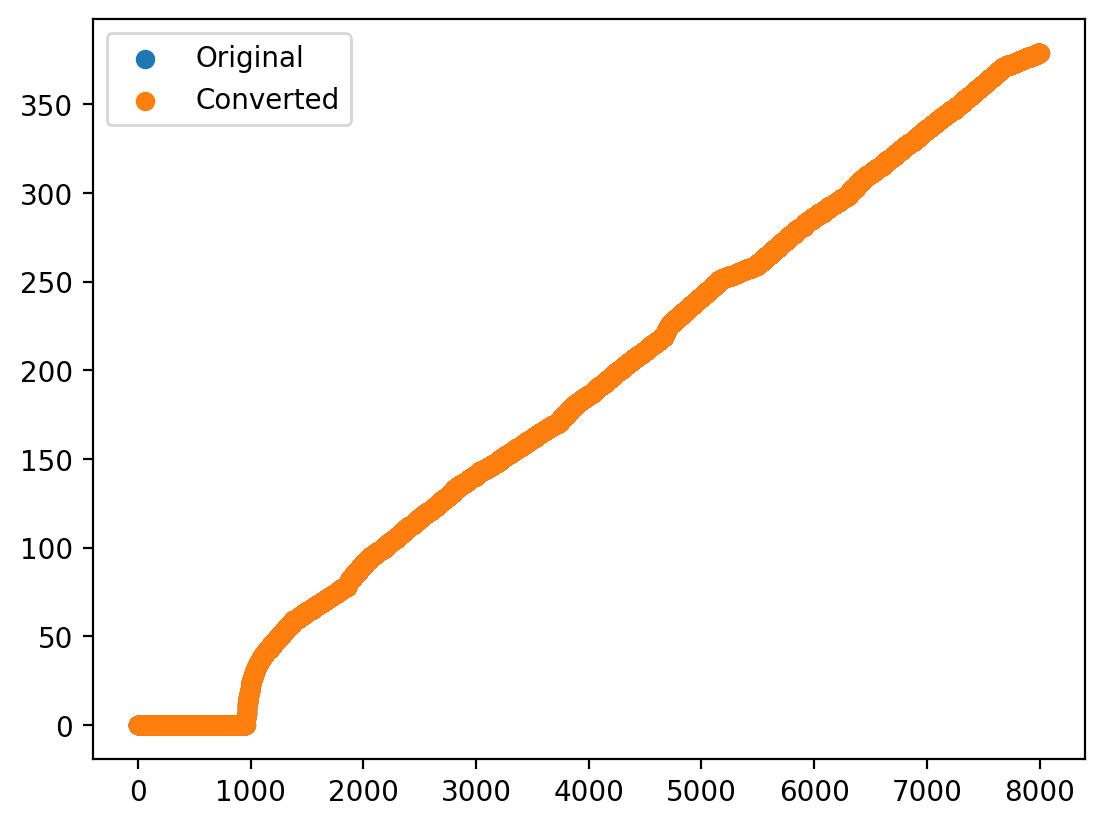

In [ ]:
# i=-8000
# j=0
# plt.scatter(range(len(note_list_original[i:,j])), note_list_original[i:,j])
# plt.scatter(range(len(note_list_converted[i:,j])), note_list_converted[i:,j])
# plt.legend(["Original", "Converted"])
# plt.show()

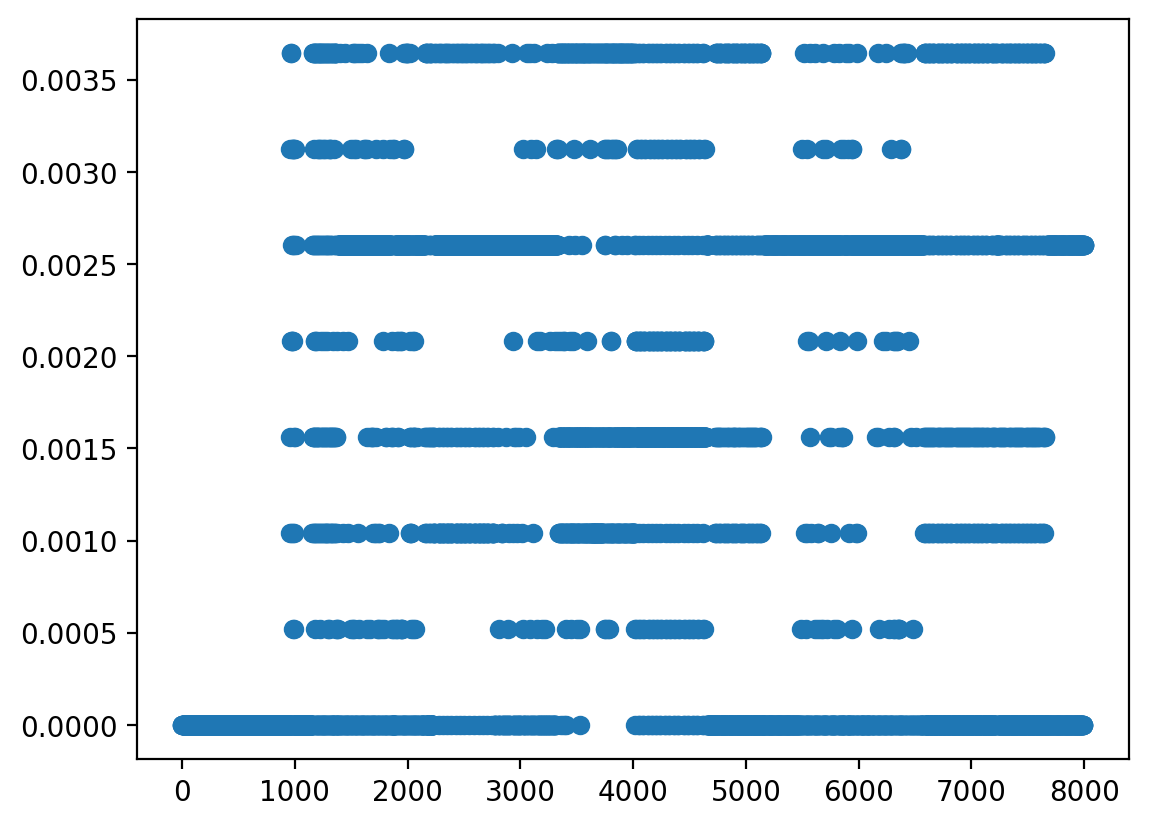

In [ ]:
# diff = np.abs(note_list_original[:, 0] - note_list_converted[:, 0])
# plt.scatter(range(len(diff[i:])), diff[i:])

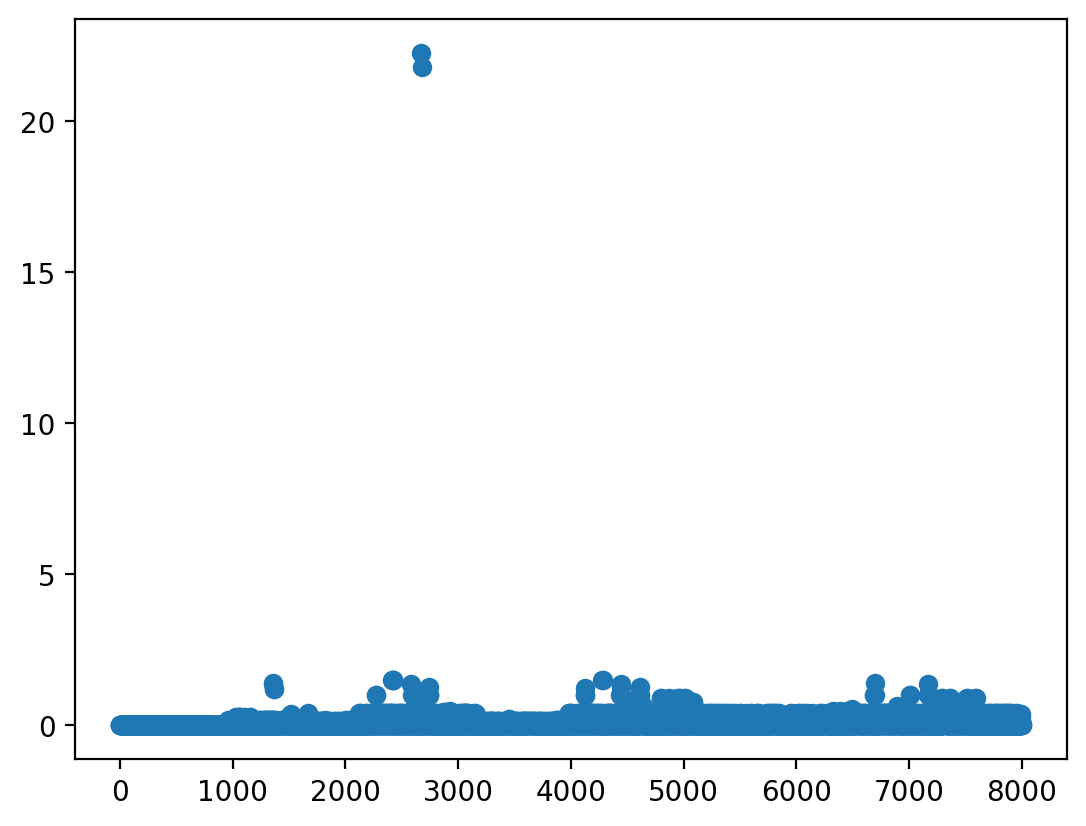

In [ ]:
# diff = np.abs(note_list_original[:, 1] - note_list_converted[:, 1])
# plt.scatter(range(len(diff[i:])), diff[i:])

In [ ]:
CREATE_WAV = True
if CREATE_WAV:
    path_original = os.path.join(ROOT_PATH, "data", "midi", "original.midi")
    path_converted = os.path.join(ROOT_PATH, "data", "midi", "converted.midi")

    muspy.outputs.write_midi(
        path=path_original,
        music=original_song,
        backend="pretty_midi",
    )

    muspy.outputs.write_midi(
        path=path_converted,
        music=converted_song,
        backend="pretty_midi",
    )

    path_wav_original = os.path.join(ROOT_PATH, "data", "wav", "original.wav")
    path_wav_converted = os.path.join(ROOT_PATH, "data", "wav", "converted.wav")

    # sounfont_path downloaded from https://www.dropbox.com/s/dl/4x27l49kxcwamp5/GeneralUser_GS_1.471.zip
    # from the download section of http://schristiancollins.com/generaluser.php
    # fluidsynth instead is installed by "brew install fluidsynth"

    soundfont_path = os.path.join(ROOT_PATH, "data", "GeneralUser GS 1.471", "GeneralUser GS v1.471.sf2")

    subprocess.run(["fluidsynth", "-F", path_wav_original, soundfont_path, path_original])
    subprocess.run(["fluidsynth", "-F", path_wav_converted, soundfont_path, path_converted])

FluidSynth runtime version 2.3.2
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file '/Users/marcelloceresini/github/MusicGeneration/data/wav/original.wav'..
FluidSynth runtime version 2.3.2
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file '/Users/marcelloceresini/github/MusicGeneration/data/wav/converted.wav'..


In [ ]:
# for time_sign in converted_song["time_signatures"]:
#     print(type(time_sign["time"]))
#     print(type(time_sign["numerator"]))
#     print(type(time_sign["denominator"]))

In [ ]:
# for time_sign in converted_song["key_signatures"]:
#     print(type(time_sign["time"]))
#     print(type(time_sign["mode"]))
#     print(type(time_sign["root"]))

In [ ]:
for track in original_song.tracks:
    print(track.program)

35
26
73
52
73
30
27
0
78
53
65
56
56
52
81


In [ ]:
converted_song.tracks[0].program

35

In [ ]:
for s in [original_song, converted_song]:
    print(s.resolution)
    for n in s.time_signatures:
        print("time=",n.time/s.resolution, "num=",n.numerator, "den=",n.denominator)
    print("--------")

480
time= 0.0 num= 4 den= 4
time= 20.0 num= 3 den= 4
time= 23.0 num= 4 den= 4
--------
128
time= 0.0 num= 4 den= 4
time= 20.0 num= 3 den= 4
time= 23.0 num= 4 den= 4
--------


In [ ]:
for i, t in enumerate(tmp_converted_song[:300]):
    print("i={:.0f} measure={:.0f} beat={:.0f} position={:.0f} duration={:.0f} t_sign={:.0f}".format(i, t[1], t[2], t[3], t[4], t[9])) if t[0] == 3 and t[6] == 26 else None

i=20 measure=0 beat=3 position=82 duration=96 t_sign=41
i=21 measure=0 beat=3 position=118 duration=96 t_sign=41
i=23 measure=1 beat=0 position=33 duration=95 t_sign=41
i=24 measure=1 beat=0 position=69 duration=94 t_sign=41
i=25 measure=1 beat=0 position=104 duration=93 t_sign=41
i=27 measure=1 beat=1 position=35 duration=91 t_sign=41
i=222 measure=10 beat=3 position=82 duration=56 t_sign=41
i=225 measure=10 beat=3 position=101 duration=55 t_sign=41
i=228 measure=10 beat=3 position=110 duration=55 t_sign=41
i=231 measure=10 beat=3 position=118 duration=55 t_sign=41
i=235 measure=11 beat=0 position=7 duration=55 t_sign=41
i=245 measure=11 beat=1 position=82 duration=56 t_sign=41
i=248 measure=11 beat=1 position=101 duration=55 t_sign=41
i=251 measure=11 beat=1 position=110 duration=55 t_sign=41
i=254 measure=11 beat=1 position=118 duration=55 t_sign=41
i=260 measure=11 beat=2 position=7 duration=55 t_sign=41
i=272 measure=11 beat=3 position=82 duration=56 t_sign=41
i=276 measure=11 bea

In [ ]:
for t in tmp_converted_song[:30]:
    print(t)

[0 0 0 0 0 0 0 0 0 0 0]
[ 1  0  0  0  0  0 35  0  0  0  0]
[ 1  0  0  0  0  0 26  0  0  0  0]
[ 1  0  0  0  0  0 73  0  0  0  0]
[ 1  0  0  0  0  0 52  0  0  0  0]
[ 1  0  0  0  0  0 73  0  0  0  0]
[ 1  0  0  0  0  0 30  0  0  0  0]
[ 1  0  0  0  0  0 27  0  0  0  0]
[  1   0   0   0   0   0 128   0   0   0   0]
[ 1  0  0  0  0  0 78  0  0  0  0]
[ 1  0  0  0  0  0 53  0  0  0  0]
[ 1  0  0  0  0  0 65  0  0  0  0]
[ 1  0  0  0  0  0 56  0  0  0  0]
[ 1  0  0  0  0  0 56  0  0  0  0]
[ 1  0  0  0  0  0 52  0  0  0  0]
[ 1  0  0  0  0  0 81  0  0  0  0]
[2 0 0 0 0 0 0 0 0 0 0]
[4 0 0 0 0 0 0 0 7 0 0]
[ 5  0  0  0  0  0  0  0  0 41  0]
[ 6  0  0  0  0  0  0  0  0  0 33]
[ 3  0  3 82 96 42 26 59  7 41 33]
[  3   0   3 118  96  49  26  66   7  41  33]
[ 3  1  0  0  2 44  0 95  7 41 33]
[ 3  1  0 33 95 54 26 67  7 41 33]
[ 3  1  0 69 94 56 26 63  7 41 33]
[  3   1   0 104  93  61  26  78   7  41  33]
[ 3  1  1  0  2 44  0 74  7 41 33]
[ 3  1  1 35 91 66 26 69  7 41 33]
[ 3  1  2  0  2 44  

In [ ]:
for i in range(1000000):
    

for s in [original_song, converted_song]:
    print(s.resolution)
    for i, n in enumerate(s.tracks[1].notes[:10]):
        print("time={:.2f} duration={:.2f} pitch={:.2f} velocity={:.2f}".format(n.time/s.resolution, n.duration/s.resolution, n.pitch, n.velocity))
    print("--------")

480
time=3.64 duration=8.64 pitch=42.00 velocity=59.00
time=3.92 duration=8.32 pitch=49.00 velocity=66.00
time=4.26 duration=7.98 pitch=54.00 velocity=67.00
time=4.54 duration=7.69 pitch=56.00 velocity=63.00
time=4.81 duration=7.44 pitch=61.00 velocity=78.00
time=5.28 duration=6.99 pitch=66.00 velocity=69.00
time=42.64 duration=1.57 pitch=47.00 velocity=82.00
time=42.79 duration=1.53 pitch=54.00 velocity=64.00
time=42.86 duration=1.52 pitch=59.00 velocity=95.00
time=42.92 duration=1.52 pitch=61.00 velocity=95.00
--------
128
time=3.64 duration=8.50 pitch=42.00 velocity=59.00
time=3.92 duration=8.50 pitch=49.00 velocity=66.00
time=4.26 duration=8.00 pitch=54.00 velocity=67.00
time=4.54 duration=7.75 pitch=56.00 velocity=63.00
time=4.81 duration=7.50 pitch=61.00 velocity=78.00
time=5.27 duration=7.00 pitch=66.00 velocity=69.00
time=42.64 duration=1.56 pitch=47.00 velocity=82.00
time=42.79 duration=1.50 pitch=54.00 velocity=64.00
time=42.86 duration=1.50 pitch=59.00 velocity=95.00
time=42

In [ ]:
i = 2100

np.max(np.sum(np.abs(note_list_original - note_list_converted), axis=1))
np.argmax(np.sum(np.abs(note_list_original - note_list_converted), axis=1))
for i in range(2030, 2110):
    n = note_list_original[i,:]
    print("{:.5f} {:.5f} {:.0f} {:.0f}".format(n[0], n[1], n[2], n[3]))
    n = note_list_converted[i,:]
    print("{:.5f} {:.5f} {:.0f} {:.0f}".format(n[0], n[1], n[2], n[3]))
    print("---")


119.45833 0.45833 105 62
119.46094 0.45312 105 62
---
119.95833 0.45833 105 59
119.96094 0.45312 105 59
---
120.45833 0.45833 104 62
120.46094 0.45312 104 62
---
121.45833 0.45833 105 66
121.46094 0.45312 105 66
---
121.95833 0.45833 104 66
121.96094 0.45312 104 66
---
122.45833 0.45833 104 66
122.46094 0.45312 104 66
---
122.95833 0.45833 105 66
122.96094 0.45312 105 66
---
123.45833 0.45833 105 62
123.46094 0.45312 105 62
---
123.95833 0.45833 104 59
123.96094 0.45312 104 59
---
125.45833 0.45833 104 66
125.46094 0.45312 104 66
---
125.95833 0.45833 105 66
125.96094 0.45312 105 66
---
126.45833 0.45833 105 65
126.46094 0.45312 105 65
---
126.95833 0.45833 104 66
126.96094 0.45312 104 66
---
127.45833 0.45833 104 62
127.46094 0.45312 104 62
---
127.95833 0.45833 105 59
127.96094 0.45312 105 59
---
128.45833 0.45833 104 62
128.46094 0.45312 104 62
---
131.72500 0.22083 1 60
130.96094 4.50000 61 83
---
132.12083 0.29167 1 60
131.72656 0.21875 1 60
---
132.50833 0.34375 1 60
132.11719 0.

In [ ]:
type(converted_song["resolution"])

int

In [ ]:
# How to write the song to the json file

# with open("output.json", "w") as f:
#     json.dump(song_in_dict, f)

In [ ]:
with open(path, "r") as f:
    tmp = json.load(f)

print(tmp.keys())

dict_keys(['metadata', 'resolution', 'tempos', 'time_signatures', 'tracks'])


In [ ]:
# tmp["tempos"]

In [ ]:
# tmp["metadata"]

In [ ]:
# tmp["tracks"][0]

In [ ]:
def find_drum_track(song):
    for track in song.tracks:
        if track.is_drum:
            return track
    return False

flag = False  
i = 0

for song in lmd_matched:
    if (track:=find_drum_track(song)):
        print(track)
        break

Track(program=0, is_drum=True, name='drums + fills       ', notes=[Note(time=6144, pitch=44, duration=32, velocity=64), Note(time=6192, pitch=44, duration=32, velocity=64), Note(time=6240, pitch=44, duration=32, velocity=64), ...])


In [ ]:
print(lmd_matched[0].tracks[0])

Track(program=62, is_drum=False, name='main synth          ', notes=[Note(time=7, pitch=69, duration=64, velocity=100), Note(time=98, pitch=76, duration=70, velocity=100), Note(time=194, pitch=74, duration=70, velocity=100), ...])


In [ ]:
for song in lmd_matched:
    if song.key_signatures != []:
        print(song.key_signatures)
        break

[KeySignature(time=0, root=9, mode='minor')]


In [ ]:
print(lmd_matched[0].tempos)


[Tempo(time=0, qpm=120.0)]
